<a href="https://colab.research.google.com/github/cyFou/testColab/blob/main/AnyDepht_PointOfCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source du tuto
https://levelup.gitconnected.com/building-a-perfect-million-parameter-llm-like-chatgpt-in-python-3b16e26b4139


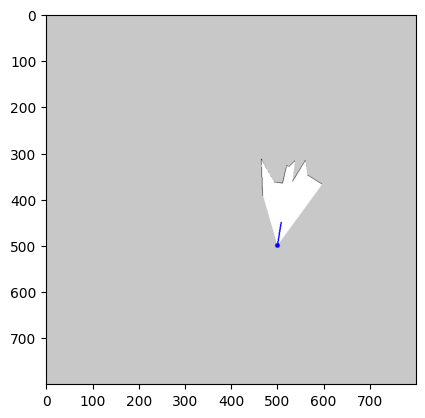

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from skimage.draw import polygon
from skimage.draw import polygon_perimeter
from skimage.draw import line


MAP_SCALE = 100        # px/m
MAP_SIZE = 800         # taille carte en px

def world_to_map(x, z):
    """Convertir coordonnées monde -> pixels carte"""
    px = int(MAP_SIZE // 2 + x * MAP_SCALE)
    pz = int(MAP_SIZE // 2 - z * MAP_SCALE)
    return px, pz

occupancy_grid = np.ones((MAP_SIZE, MAP_SIZE), dtype=np.int8) * -1

def draw_map():
    """Convertir la grille d’occupation en image affichable"""
    img = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)
    img[occupancy_grid == -1] = (200, 200, 200)  # inconnu
    img[occupancy_grid == 0] = (255, 255, 255)  # libre
    img[occupancy_grid == 1] = (0, 0, 0)        # obstacle

    return img

px = 1
pz = -1
zy = -10

# Matrice de rotation autour de Y (dans le plan XZ)
world_matrix = np.array([
        [np.cos(math.radians(zy)), -np.sin(math.radians(zy)),px],
        [np.sin(math.radians(zy)),  np.cos(math.radians(zy)),pz],
        [0,0,1]
    ])

map_matrix =([
    [MAP_SCALE,0,MAP_SIZE // 2],
    [0,-MAP_SCALE,MAP_SIZE // 2],
    [0,0,1]
    ])

robot_matrix = map_matrix @ world_matrix

clip_distance_max = 2
nbP = 200
#lidar = np.ones(nbP) * 3.0
lidar = np.random.uniform(low=1, high=4, size=nbP)
#px,pz = world_to_map(px,pz)

# les point de depth
fov = 60
W = nbP
fx = W / (2 * math.tan(math.radians(fov / 2)))
cx = W / 2

#ramener les point du lidar dans le repère du monde
step_px = 5
lidar = lidar[::step_px]
r = np.arange(0,W,step_px,float)
valid = (lidar > 0) & (lidar < clip_distance_max) #remove from the depth image all values above a given value (meters).
valid = np.ravel(valid)
lidar = lidar[valid]
r=r[valid]
X = lidar * (r-cx) / fx
Z = lidar
X = np.stack((X,Z,np.ones(X.shape[0])))
X = robot_matrix  @ X

# ligne pour les obstacles
#occupancy_grid[polygon_perimeter(X[1],X[0])] = 1
for u in range(1,X.shape[1]):
  occupancy_grid[line(int(X[1,u]), int(X[0,u]),int(X[1,u-1]), int(X[0,u-1]))]=1


#zone libre
X = np.hstack((X, map_matrix @ np.array([[px], [pz], [1.0]])) )
rr, cc = polygon(X[1], X[0], occupancy_grid.shape)
occupancy_grid[rr, cc] = 0

#position du robot
minimap = draw_map()
cv2.circle(minimap, world_to_map(px,pz), 5, (0, 0, 255), -1)

# Dessiner l'orientation
l = world_matrix @ np.array([0, 0.5,1])
cv2.line(minimap, world_to_map(px,pz), world_to_map(l[0], l[1]), (0, 0, 255), 2)

# Display the array as a grayscale image
plt.imshow(minimap)
plt.show()

In [ ]:
X, Y = np.mgrid[0:1:5j, 0:1:5j]
x, y = X.ravel(), Y.ravel()
plt.rcParams['figure.figsize'] = (16, 4)

def trans_rotate(x, y, px, py, beta):
    beta = np.deg2rad(beta)
    T = [[np.cos(beta), -np.sin(beta), px*(1 - np.cos(beta)) + py*np.sin(beta)],
         [np.sin(beta),  np.cos(beta), py*(1 - np.cos(beta)) - px*np.sin(beta)],
         [0           ,  0           , 1                                      ]]
    T = np.array(T)
    P = np.array([x, y, [1]*x.size])
    return np.dot(T, P)

fig, ax = plt.subplots(1, 4)

R_ = [0, 225, 40, -10]
P_ = [[0, 0], [0, 0], [0.5, -0.5], [1.1, 1.1]]

print(x)

for i in range(4):
    beta = R_[i]; px, py = P_[i]
    x_, y_, _ = trans_rotate(x, y, px, py, beta)
    ax[i].scatter(x_, y_)
    ax[i].scatter(px, py)
    ax[i].set_title(r'$\beta={0}°$ , $p_x={1:.2f}$ , $p_y={2:.2f}$'.format(beta, px, py))

    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].grid(alpha=0.5)
    ax[i].axhline(y=0, color='k')
    ax[i].axvline(x=0, color='k')

plt.show()

In [ ]:
pip install ai2thor pillow numpy

In [ ]:
!pip install --upgrade ai2thor ai2thor-colab &> /dev/null
import ai2thor
import ai2thor_colab

from ai2thor.controller import Controller
from ai2thor_colab import (
    plot_frames,
    show_objects_table,
    side_by_side,
    overlay,
    show_video
)

ai2thor_colab.start_xserver()

"AI2-THOR Version: " + ai2thor.__version__
controller = Controller(
        renderDepthImage=True,
)

plot_frames(controller.last_event)

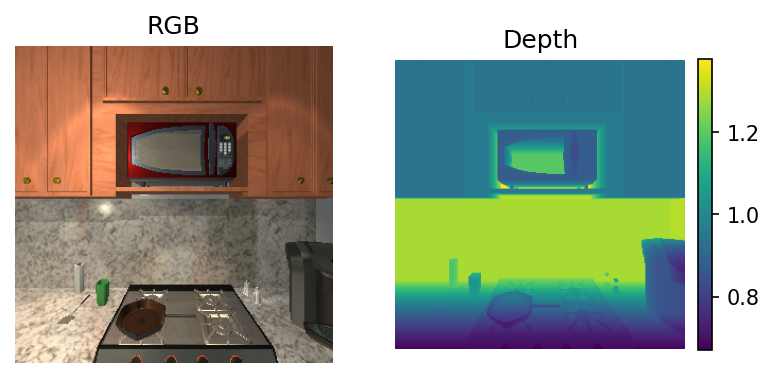

In [ ]:
plot_frames(controller.last_event)

In [ ]:
controller.reset(
    # makes the images a bit higher quality
    #width=200,
    #height=200,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)

plot_frames(controller.last_event)

In [ ]:
#source de ce test : https://medium.com/data-science-collective/depthanything-v2-tutorial-how-to-convert-2d-images-to-3d-models-with-python-2708d295b7e5

In [ ]:
# Install Open3D for point cloud and mesh processing
!pip install open3d

In [16]:
import os
import random
from pathlib import Path
import requests

import numpy as np
import matplotlib.pyplot as plt
import cv2

import open3d as o3d

import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

#Step 2: Preparing Your Image Data

# Download the image from the URL
image_url = ["https://www.sncf-connect.com/assets/styles/ratio_2_1_max_width_961/public/media/2021-08/pont-avignon-istock-extravagantni.jpg",
             "https://www.index-assurance.fr/fichiers/images/peugeot-208-allure.jpg"]

liste_image = []
for img in image_url:
  response = requests.get(img)
  image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
  selected_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
  selected_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)
  liste_image.append(selected_image)

In [20]:
#Step 3: Understanding and Loading Depth Anything v2
checkpoints = [
    "Intel/zoedepth-nyu-kitti",
    "LiheYoung/depth-anything-large-hf",
    "jingheya/lotus-depth-g-v1-0",
    "tencent/DepthCrafter"
    ]

checkpoint = checkpoints[1]
device = "cpu"
# take care of the necessary image transformations such as resizing and normalization
processor = AutoImageProcessor.from_pretrained(checkpoints[1])
model = AutoModelForDepthEstimation.from_pretrained(checkpoints[1]).to(device)

#Step 4: Processing Images for Depth Estimation
num_samples = 2
depth_samples = []
for i in range(num_samples):
    depth_input = processor(images=liste_image[i], return_tensors="pt").to(device)

    # Infer model
    with torch.no_grad():
        inference_outputs = model(**depth_input)
        output_depth = inference_outputs.predicted_depth

    output_depth = output_depth.squeeze().cpu().numpy()

    depth_samples.append([liste_image[i], output_depth])

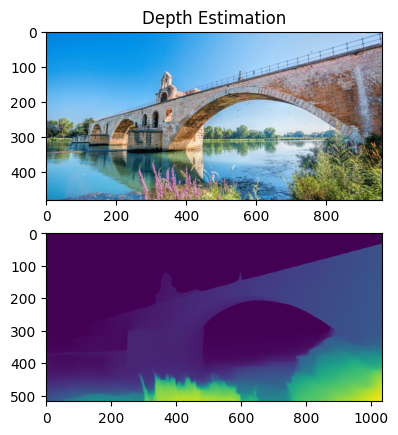

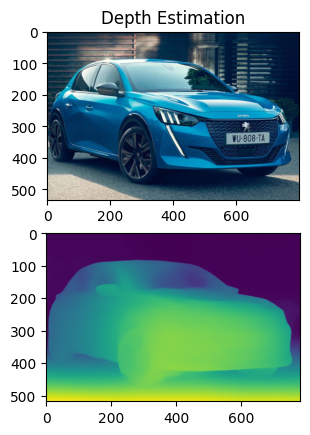

In [22]:
#Step 5: Visualizing Depth Maps
plt.rcParams['figure.dpi'] = 100

for i in range(num_samples):
    fig, axs = plt.subplots(2, 1)

    axs[0].imshow(depth_samples[i][0])
    axs[0].set_title('Depth Estimation')
    axs[1].imshow(depth_samples[i][1])

    plt.show()

In [ ]:
#enregistrement des images
if False:
  for i in range(num_samples):
      depth_image = depth_samples[i][1]
      color_image = depth_samples[i][0]
      width, height = depth_image.shape

      depth_image = (depth_image * 255 / np.max(depth_image)).astype('uint8')
      color_image = cv2.resize(color_image, (height, width))

      cv2.imwrite('../RESULTS/'+str(i)+'.png', cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
      cv2.imwrite('../RESULTS/'+str(i)+'_depth.png', depth_image)

In [ ]:
https://colab.research.google.com/drive/1CR_HDvJ2AnjJV3Bf5vwP70K0hx3RcdMb?usp=sharing

In [23]:
#Step 6: Generating 3D Point Clouds with the Pinhole Method
i = 0

depth_image = depth_samples[i][1]
color_image = depth_samples[i][0]
width, height = depth_image.shape

depth_image = (depth_image * 255 / np.max(depth_image)).astype('uint8')
color_image = cv2.resize(color_image, (height, width))


depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(color_image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()

# If focal length is too small: Objects appear "stretched" in depth
# If focal length is too large: Objects appear "compressed" in depth

# to create metrically accurate 3D reconstructions that match real-world scale:
fx = fy = width * 0.8  # A good approximation for a standard lens
cx, cy = width/2, height/2  # Center of the image

camera_intrinsic.set_intrinsics(width, height, fx, fy, cx, cy)

pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

o3d.visualization.draw_geometries([pcd_raw])

[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
# Convert the image to RGB
selected_image_rgb = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(selected_image_rgb)
plt.axis('off')  # Hide axes
plt.show()